


---


---


1. IMPORT LIBRARIES


---


---




In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score




---



---


2. Load Dataset


---


---





In [42]:
df = pd.read_csv("/content/drive/MyDrive/Sample - Superstore.csv", encoding='latin1')
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164




---



---


3. DATA CLEANING & PREPROCESSING


---



---



In [43]:
# Drop duplicates
df = df.drop_duplicates()

# Handle Missing Values
df = df.fillna({
    "Sales": df["Sales"].median(),
    "Profit": df["Profit"].median(),
    "Discount": df["Discount"].median()
})

# Convert Order Date
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])

# Feature Engineering
df['Year'] = df['Order Date'].dt.year
df['Month'] = df['Order Date'].dt.month
df['Day'] = df['Order Date'].dt.day
df['Profit Margin'] = df['Profit'] / df['Sales']



---



---



4. OUTLIER REMOVAL (IQR METHOD)

---



---



In [44]:
num_cols = ['Sales', 'Profit', 'Quantity', 'Discount']

for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower) & (df[col] <= upper)]



---


---


5. EXPORT CLEANED DATA FOR POWER BI



---


---





In [45]:
df.to_csv("clean_superstore.csv", index=False)



---



---


6. EXPLORATORY DATA ANALYSIS (All Visuals)


---



---



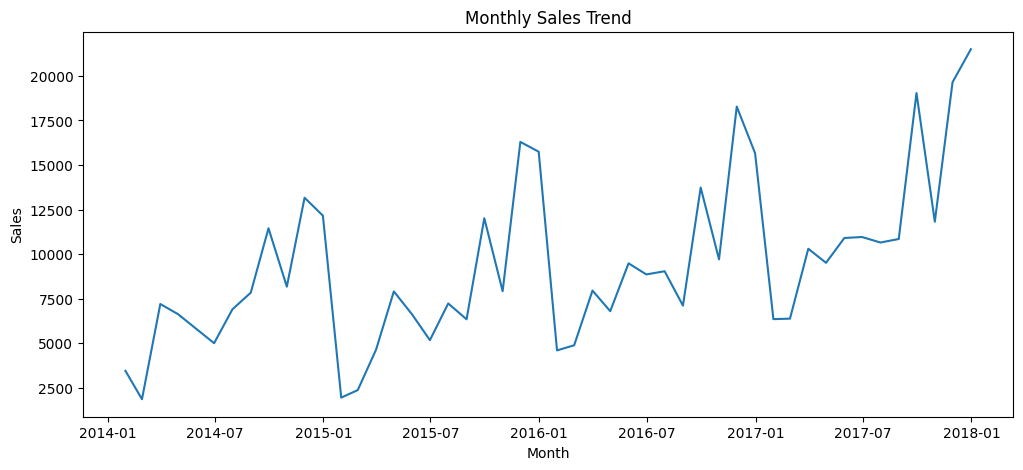

In [46]:
# Sales Trend

# Ensure Order Date is datetime
df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')
df = df.dropna(subset=['Order Date'])
df = df.sort_values('Order Date')
df = df.set_index('Order Date')

#Only numeric columns for monthly grouping
df_monthly = df.select_dtypes(include='number').resample('ME').sum()

plt.figure(figsize=(12,5))
sns.lineplot(data=df_monthly, x=df_monthly.index, y='Sales')
plt.title("Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.show()


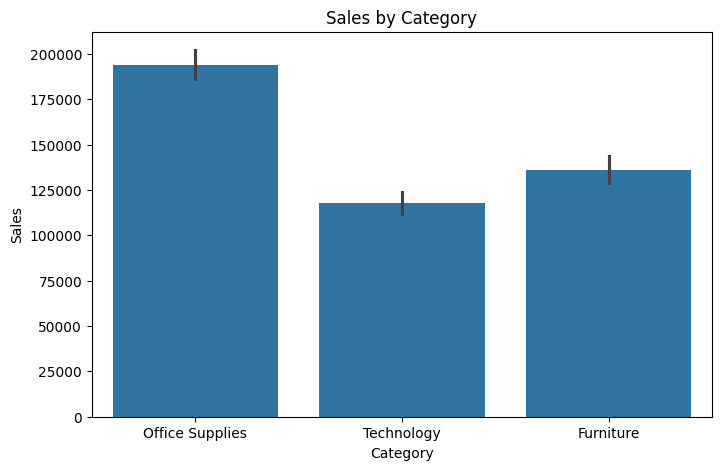

In [47]:
# Category-Wise Sales
plt.figure(figsize=(8,5))
sns.barplot(data=df, x='Category', y='Sales', estimator=sum)
plt.title("Sales by Category")
plt.show()

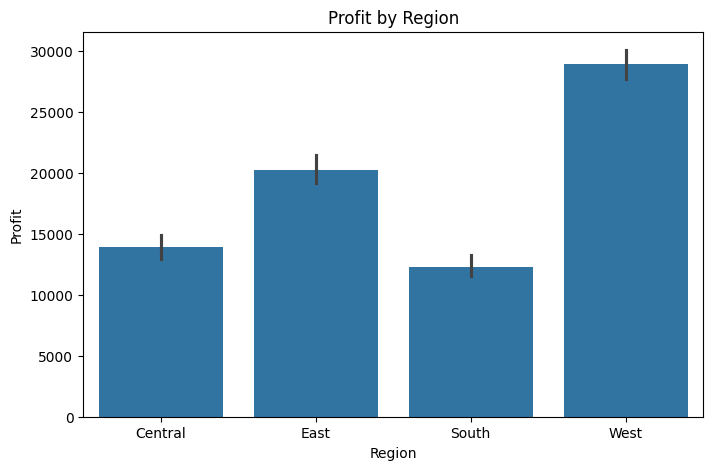

In [48]:
# Region-wise Profit
plt.figure(figsize=(8,5))
sns.barplot(data=df, x='Region', y='Profit', estimator=sum)
plt.title("Profit by Region")
plt.show()

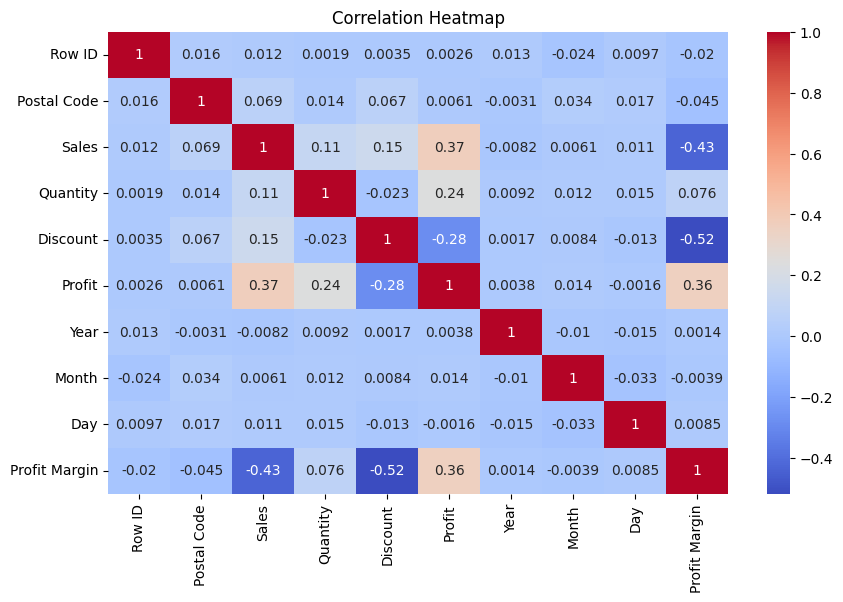

In [51]:
# Correlation Heatmap

# Select only numeric columns
numeric_df = df.select_dtypes(include='number')

# Correlation Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()




---



---


7. RANDOM FOREST MODEL FOR SALES PREDICTION


---



---



In [52]:
# Select Features
features = ['Quantity', 'Discount', 'Profit', 'Profit Margin', 'Year', 'Month']
X = df[features]
y = df['Sales']

In [53]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [54]:
# Train Random Forest
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=42)

In [56]:
# Predictions

y_pred = rf.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

MSE: 256.81932085292766
R² Score: 0.9649842042250834




---



---


8. FEATURE IMPORTANCE CHART


---



---



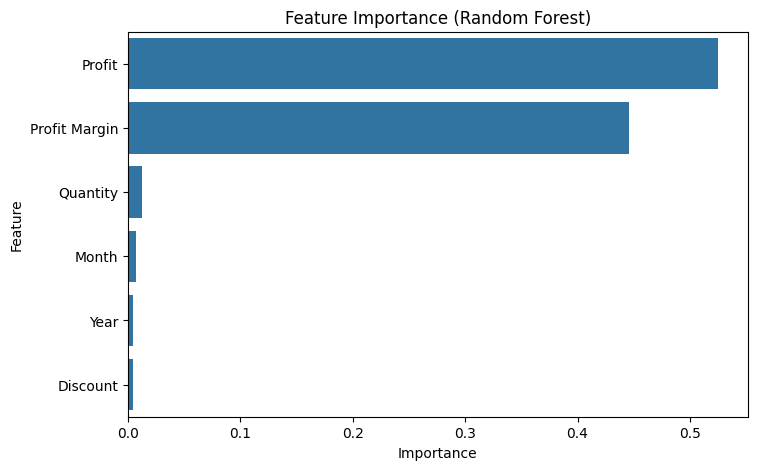

In [57]:
imp = pd.DataFrame({
    'Feature': features,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(data=imp, x='Importance', y='Feature')
plt.title("Feature Importance (Random Forest)")
plt.show()
